In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from scipy.interpolate import griddata
from numpy.random import uniform, seed
from matplotlib import cm

We change notation for convinience 

$S = X$

$X = Z$

$\vec{X_{k+1}} = F\vec{X_{k}} + \vec{W}$

$\vec{Z_k} = H\vec{X_k} + \vec{V}$

$X_{k+1} = \begin{bmatrix}x_{k+1} \\ \dot{x_{k+1}} \end{bmatrix}$
$F = \begin{bmatrix}1 & \Delta{t} \\ 0 & 1 \end{bmatrix}$
$H = \begin{bmatrix} 1 & 0 \\ 0 & 0\end{bmatrix}$

$W = N(0,Q)$

$V = N(0,R)$

Q and R are the covariances matrices

$\begin{bmatrix}x_{k+1} \\ \dot{x_{k+1}} \end{bmatrix} = \begin{bmatrix}1 & \Delta{t} \\ 0 & 1 \end{bmatrix} \begin{bmatrix}x_{k} \\ \dot{x_{k}} \end{bmatrix} + \vec{W}$

${Z_k} = \begin{bmatrix} 1 & 0 \end{bmatrix}\begin{bmatrix}x_{k} \\ \dot{x_{k}} \end{bmatrix} + \vec{V}$

if $\dot{x_k} = 1$ and $\Delta{t} = 1$

Same problem

## Update (Multiplication or N dimensional normal pdfs)

https://www.cs.nyu.edu/~roweis/notes/gaussid.pdf

$N(c,C) = \alpha N(a,A)N(b,B) $

$ C = (A^{-1} + B^{-1})^{-1}$

$ c = CA^{-1}a + CB^{-1}b$

In [12]:
def gauss_pdfs_mult(a,A,b,B):
    A_1 = np.linalg.inv(A)
    B_1 = np.linalg.inv(B)
    C = np.linalg.inv(A_1 + B_1)
    c = C.dot(A_1).dot(a) + C.dot(B_1).dot(b)
    return c, C

## Applied to our problem

$\vec{Z_k} = H\vec{X_k} + \vec{V}$

$\large{p(X_k|Z_k) = \alpha p(Z_k|X_k)p(X_K)}$

$a = \mu_{z_k} = H \vec{\mu_{x_k}} \quad A = R \quad b=\vec{\mu_{X_k}} \quad  B = \Sigma_{X_k} $ 

$C$ = $\Sigma_{X_k}^{updated} \quad c=\vec{\mu_{X_k}}^{updated}$

$P_k = \Sigma_{X_k}^{ud} = (R^{-1} + \Sigma_{X_k}^{-1})^{-1}$

$\hat{X_k} = \vec{\mu_x^{ud}} = P_kR^{-1}H\vec{\mu_{X_k}}+P_k\Sigma_{X_k}^{-1}\vec{\mu_{X_k}}$

In [71]:
def update(H, R, sigma_x, mu_x):
    H= np.array(H)
    return gauss_pdfs_mult(H.dot(mu_x), R, mu_x, sigma_x)

In [97]:
def gauss(x,y,Sigma,mu):
    X=np.vstack((x,y)).T
    mat_multi=np.dot((X-mu[None,...]).dot(np.linalg.inv(Sigma)),(X-mu[None,...]).T)
    return  np.diag(np.exp(-1*(mat_multi)))

def plot_countour(x,y,z, limits, color = 'r'):
    # define grid.
    xi = np.linspace(limits[0], limits[1], 100)
    yi = np.linspace(limits[2], limits[3], 100)
    ## grid the data.
    zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')
    levels = [0.85, 0.9, 0.95]
    n_levels = len(levels)
    #n_levels = 10
    # contour the gridded data, plotting dots at the randomly spaced data points.
    #CS = plt.contour(xi,yi,zi,len(levels),linewidths=0.5,colors='k', levels=levels)
    #CS = plt.contourf(xi,yi,zi,15,cmap=plt.cm.jet)
    #CS = plt.contourf(xi,yi,zi,n_levels,cmap=cm.Greys_r, levels=levels)
    
    #CS = plt.contourf(xi,yi,zi,n_levels,cmap=cm.Greys_r)
    CS = plt.contour(xi,yi,zi,n_levels,linewidths=0.5,colors=color, levels=levels)
    
    #plt.colorbar() # draw colorbar
    # plot data points.
    # plt.scatter(x, y, marker='o', c='b', s=5)
    #plt.xlim(-2, 2)
    #plt.ylim(-2, 2)
    
def plot_2d_gauss(mu ,Sigma ,npts = 1000, color='r',limits = [-1,2, -1.5,2.5]):
    x = uniform(limits[0], limits[1], npts)
    y = uniform(limits[2], limits[3], npts)
    z = gauss(x,y,Sigma,mu)
    plot_countour(x,y, z, limits = limits, color = color)

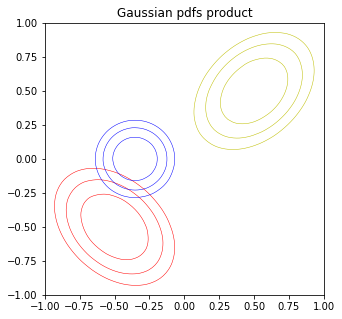

In [153]:
plt.figure(figsize = (5,5))  

zero_mean = np.array([-0.5 , -0.5])
R = np.array([[1, -0.707],[0 ,1]])

mu_x = np.array([0.5 , 0.5])
sigma_x = np.array([[1, 0.707],[0 ,1]])
limit = 1
plot_2d_gauss(zero_mean, R, color='r', limits = [-limit,limit, -limit,limit])
plot_2d_gauss(mu_x, sigma_x, color='y', limits = [-limit,limit, -limit,limit])

mean, P = gauss_pdfs_mult(zero_mean, R, mu_x, sigma_x)
plot_2d_gauss(mean, P, color = 'b' , limits = [-limit,limit, -limit,limit])
plt.title('Gaussian pdfs product')
plt.show()

## Observed position but not speed

[ 0.  0.]
[[ 0.83333333  0.        ]
 [ 0.          4.97512438]]


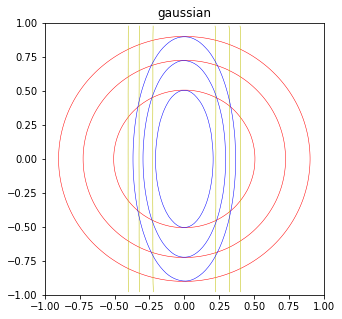

In [168]:
plt.figure(figsize = (5,5))  
H = np.array([[1, 0],[0,1]])
# a priori estimates
mu_x = np.array([0 , 0])
sigma_x = np.array([[5, 0],[0 ,5]])

# Observation distribution
mu_z = H.dot(mu_x)
# speed variance = infinite
R = np.array([[1, 0],[0 ,1000]])

plot_2d_gauss(mu_x, sigma_x, limits = [-limit,limit, -limit,limit], color = 'r')
plot_2d_gauss(mu_z, R, limits = [-limit,limit, -limit,limit], color = 'y')

mean, P = update(H, R, sigma_x, mu_x)
print(mean)
print(P)
plot_2d_gauss(mean, P, limits = [-limit,limit, -limit,limit], color = 'b')